In [ ]:
!pip install catboost shap imbalanced-learn scikit-learn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("/content/cell2celltrain.csv")

# Drop columns with too many nulls or IDs
df.drop(columns=["CustomerID", "HandsetRefurbished", "HandsetWebCapable"], inplace=True)

# Convert target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Fill numeric nulls with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode categoricals
cat_cols = df.select_dtypes(include="object").columns
encoders = {col: LabelEncoder().fit(df[col].astype(str)) for col in cat_cols}
for col in cat_cols:
    df[col] = encoders[col].transform(df[col].astype(str))

# Features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100
)

clf.fit(X_train, y_train)


0:	total: 104ms	remaining: 31s
100:	total: 7.27s	remaining: 14.3s
200:	total: 13.4s	remaining: 6.62s
299:	total: 17.2s	remaining: 0us


Accuracy: 0.7970416236670107
Precision: 0.9086997193638915
Recall: 0.6636152479846974
F1 Score: 0.7670562223626026
MCC: 0.6179877426428337
ROC AUC: 0.8643187407619024


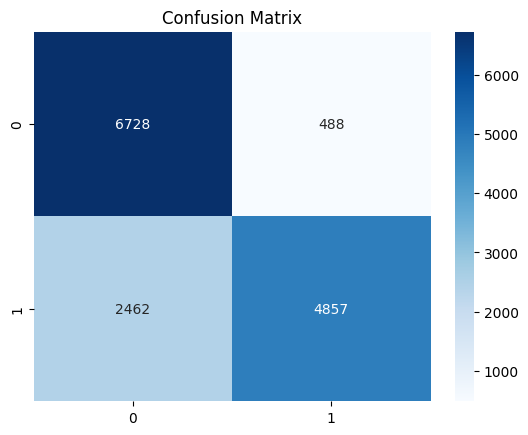

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

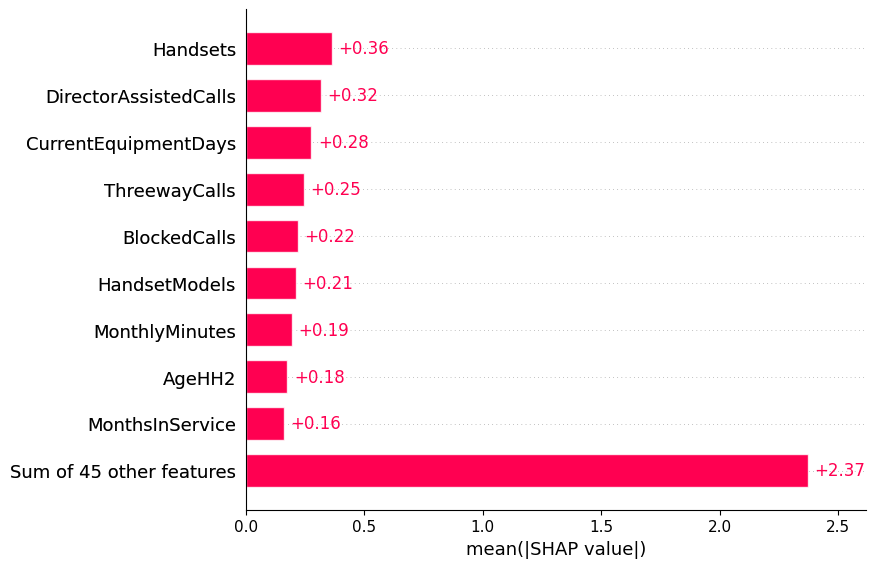

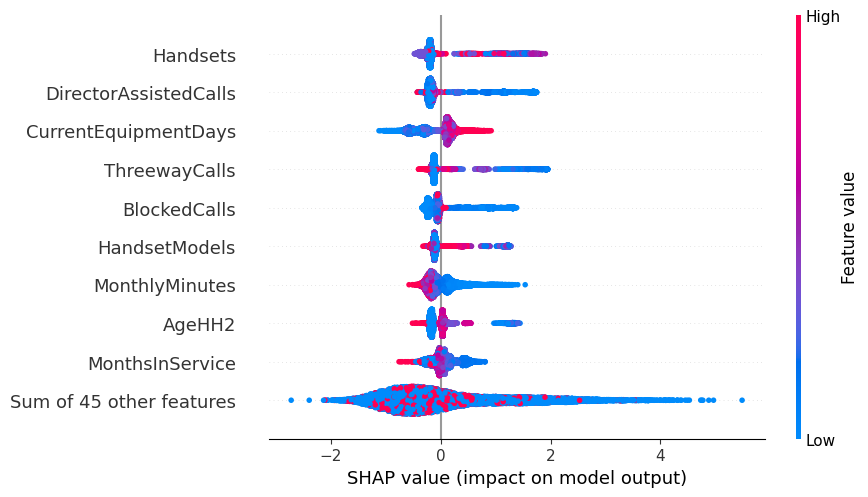

In [ ]:
import shap

explainer = shap.Explainer(clf)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)